Este proyecto analiza el flujo de pasajeros del Metro de Santo Domingo usando datos de peaje acumulado por estación. El objetivo es identificar patrones de movilidad, estaciones con mayor demanda y posibles necesidades de mejora operativa. El análisis combina limpieza de datos, estadística descriptiva y visualizaciones para obtener insights relevantes.

In [2]:
    pip install scipy

     --------------------------------------- 41.3/41.3 MB 22.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Treisi\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from scipy.stats import skew, kurtosis, zscore

In [ ]:
#Carga y Revision Inicial del dataset

In [4]:
df_metro = pd.read_excel("Peaje Acumulado Por Estación METRO.xlsx")

In [5]:
df_metro.info()
df_metro.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   ESTACIONES                        3048 non-null   object
 1   CALLE PROXIMAS A LAS ESTACIONES   3048 non-null   object
 2   MES                               3048 non-null   object
 3   AnO                               3048 non-null   int64 
 4   LINEA                             3048 non-null   int64 
 5   LABORABLES                        3048 non-null   int64 
 6   SABADOS                           3048 non-null   int64 
 7   FESTIVOS                          3048 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 190.6+ KB


(3048, 8)

In [6]:
df_metro.head()

,ESTACIONES,CALLE PROXIMAS A LAS ESTACIONES,MES,AnO,LINEA,LABORABLES,SABADOS,FESTIVOS
0,Centro de los Heroes,Av Enrique Jimenez Moya,Enero,2018,1,439813,44119,37843
1,Francisco A Caamano,Universidad Dominico Americana,Enero,2018,1,123418,10894,8054
2,Amin Abel,UASD,Enero,2018,1,158756,9496,7083
3,Joaquin Balaguer,Ministerio de Educacion,Enero,2018,1,236942,21039,19121
4,Casandra Damiron,Teatro Nacional y Plaza de la Cultura,Enero,2018,1,142563,10184,7344


Estadisticas -Antes del tratamiento

In [7]:
for c in ["LABORABLES","SABADOS","FESTIVOS"]:
    df_metro[c] = pd.to_numeric(df_metro[c], errors="coerce")

In [8]:
def calc_stats(s: pd.Series):
    s = s.dropna()
    media = s.mean()
    mediana = s.median()
    moda_vals = s.mode()
    moda = moda_vals.iloc[0] if len(moda_vals) else np.nan
    desv = s.std(ddof=1)
    rango = s.max() - s.min()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    asim = skew(s, bias=False)
    curt = kurtosis(s, fisher=True, bias=False)  
    return [media, mediana, moda, desv, rango, iqr, asim, curt]

cols = ["LABORABLES","SABADOS","FESTIVOS"]

stats_antes = pd.DataFrame(
    {col: calc_stats(df_metro[col]) for col in cols},
    index=["Media","Mediana","Moda","Desviación estándar","Rango","IQR","Asimetría","Curtosis"]
).round(2)

stats_antes

,LABORABLES,SABADOS,FESTIVOS
Media,1039181.85,133924.45,90197.35
Mediana,669317.00,85590.50,55138.00
Moda,0.00,0.00,0.00
Desviación estándar,1170445.23,160980.07,112307.76
Rango,8405244.00,1198063.00,890607.00
IQR,1051626.75,132049.75,80008.25
Asimetría,2.55,2.89,3.11
Curtosis,8.25,10.75,12.31


In [ ]:
#Histogramas antes de la preparacion 

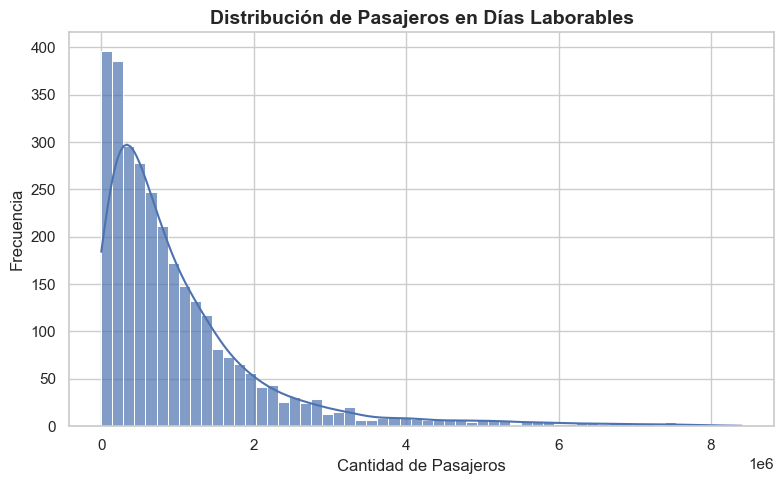

FileNotFoundError: [Errno 2] No such file or directory: 'graficos/hist_laborables.png'

<Figure size 640x480 with 0 Axes>

In [26]:
sns.set(style="whitegrid")  

for col in ["LABORABLES", "SABADOS", "FESTIVOS"]:
    plt.figure(figsize=(8,5))
    sns.histplot(df_metro[col], kde=True, alpha=0.7)
    
    plt.title(f"Distribución de Pasajeros en Días {col.capitalize()}", fontsize=14, weight='bold')
    plt.xlabel("Cantidad de Pasajeros")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    plt.savefig("graficos/hist_laborables.png", dpi=300, bbox_inches='tight')


In [ ]:
# Preparación de Datos (Limpieza)

In [10]:
df_metro.columns = df_metro.columns.str.lower().str.replace(" ", "_")
df_metro.isnull().sum()
df_metro.duplicated().sum()


np.int64(0)

In [11]:
df_metro.columns = df_metro.columns.str.upper()
df_metro.columns = df_metro.columns.str.strip()
df_metro.head()

,ESTACIONES,CALLE_PROXIMAS_A_LAS_ESTACIONES_,MES,ANO,LINEA,LABORABLES,SABADOS,FESTIVOS
0,Centro de los Heroes,Av Enrique Jimenez Moya,Enero,2018,1,439813,44119,37843
1,Francisco A Caamano,Universidad Dominico Americana,Enero,2018,1,123418,10894,8054
2,Amin Abel,UASD,Enero,2018,1,158756,9496,7083
3,Joaquin Balaguer,Ministerio de Educacion,Enero,2018,1,236942,21039,19121
4,Casandra Damiron,Teatro Nacional y Plaza de la Cultura,Enero,2018,1,142563,10184,7344


In [12]:
df_metro = df_metro.drop_duplicates()
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   ESTACIONES                        3048 non-null   object
 1   CALLE_PROXIMAS_A_LAS_ESTACIONES_  3048 non-null   object
 2   MES                               3048 non-null   object
 3   ANO                               3048 non-null   int64 
 4   LINEA                             3048 non-null   int64 
 5   LABORABLES                        3048 non-null   int64 
 6   SABADOS                           3048 non-null   int64 
 7   FESTIVOS                          3048 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 190.6+ KB


In [13]:
#Se verificó la ausencia de valores negativos
(df_metro[["ANO","LINEA","LABORABLES","SABADOS","FESTIVOS"]]< 0).sum()

ANO           0
LINEA         0
LABORABLES    0
SABADOS       0
FESTIVOS      0
dtype: int64

Discretizacion: Con pd.qcut(), que divide una columna numérica en cuantiles o intervalos iguales en cantidad

In [14]:
df_metro["TRAFICO_LAB"] = pd.qcut(df_metro["LABORABLES"], q=3, labels=["Bajo","Medio","Alto"])
df_metro["TRAFICO_SAB"] = pd.qcut(df_metro["SABADOS"], q=3, labels=["Bajo","Medio","Alto"])
df_metro["TRAFICO_FES"] = pd.qcut(df_metro["FESTIVOS"], q=3, labels=["Bajo","Medio","Alto"])

In [15]:
df_metro

,ESTACIONES,CALLE_PROXIMAS_A_LAS_ESTACIONES_,MES,ANO,LINEA,LABORABLES,SABADOS,FESTIVOS,TRAFICO_LAB,TRAFICO_SAB,TRAFICO_FES
0,Centro de los Heroes,Av Enrique Jimenez Moya,Enero,2018,1,439813,44119,37843,Medio,Bajo,Medio
1,Francisco A Caamano,Universidad Dominico Americana,Enero,2018,1,123418,10894,8054,Bajo,Bajo,Bajo
2,Amin Abel,UASD,Enero,2018,1,158756,9496,7083,Bajo,Bajo,Bajo
3,Joaquin Balaguer,Ministerio de Educacion,Enero,2018,1,236942,21039,19121,Bajo,Bajo,Bajo
4,Casandra Damiron,Teatro Nacional y Plaza de la Cultura,Enero,2018,1,142563,10184,7344,Bajo,Bajo,Bajo
...,...,...,...,...,...,...,...,...,...,...,...
3043,Eduardo Brito,Av Francisco del Rosario Sanchez,JULIO,2025,2,944426,154911,122349,Medio,Alto,Alto
3044,Ercilia Pepin,Av Venezuela,JULIO,2025,2,889313,124349,91792,Medio,Medio,Alto
3045,Rosa Duarte,Av Fernando de Navarrete,JULIO,2025,2,1076312,158477,121303,Alto,Alto,Alto
3046,Trina de Moya,Av Trina de Moya,JULIO,2025,2,793707,91875,63360,Medio,Medio,Medio


Outliers (valores atípicos) - Uso de boxplot, z-score y IQR 

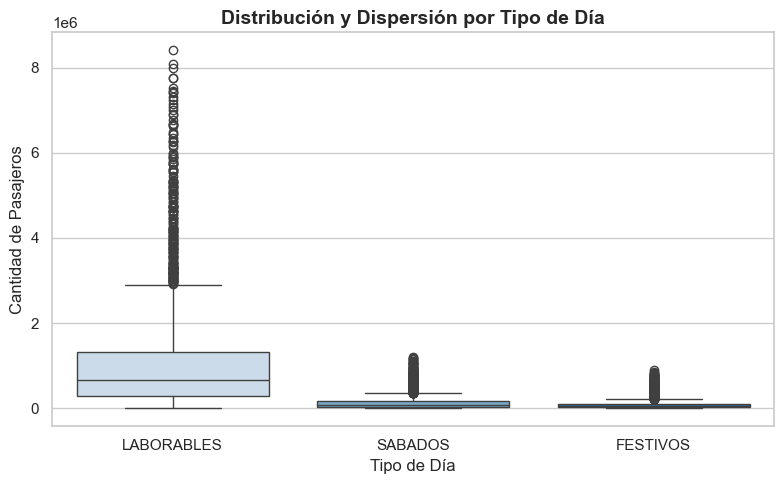

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_metro[["LABORABLES","SABADOS","FESTIVOS"]], palette="Blues")
plt.title("Distribución y Dispersión por Tipo de Día", fontsize=14, weight='bold')
plt.ylabel("Cantidad de Pasajeros")
plt.xlabel("Tipo de Día")
plt.tight_layout()
plt.show()


In [17]:
#Z-score

z_scores = np.abs(zscore(df_metro[["LABORABLES","SABADOS","FESTIVOS"]]))
print(z_scores)


[[0.51217023 0.55795842 0.4662451 ]
 [0.78253479 0.7643843  0.73153298]
 [0.75233791 0.77307003 0.74018029]
 ...
 [0.0317283  0.15254421 0.27701337]
 [0.20976217 0.26125191 0.23900179]
 [2.57338335 2.4691116  2.29513913]]


In [18]:
#IQR

df_sin_outliers = df_metro.copy()

cols = ["LABORABLES", "SABADOS", "FESTIVOS"]

for col in cols:
    Q1 = df_sin_outliers[col].quantile(0.25)
    Q3 = df_sin_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    lim_inf = Q1 - 1.5*IQR
    lim_sup = Q3 + 1.5*IQR

    outliers = df_metro[(df_metro[col] < lim_inf) | (df_metro[col] > lim_sup)]

    print(f"\n {col}")
    print(f"Límite inferior: {lim_inf:.2f}, Límite superior: {lim_sup:.2f}")
    print(f"Cantidad de outliers detectados: {outliers.shape[0]}")

df_sin_outliers[col] = np.where(df_sin_outliers[col] > lim_sup, lim_sup,
                                    np.where(df_sin_outliers[col] < lim_inf, lim_inf, df_sin_outliers[col]))
 



 LABORABLES
Límite inferior: -1296506.62, Límite superior: 2910000.38
Cantidad de outliers detectados: 194

 SABADOS
Límite inferior: -163468.62, Límite superior: 364730.38
Cantidad de outliers detectados: 217

 FESTIVOS
Límite inferior: -94450.62, Límite superior: 225582.38
Cantidad de outliers detectados: 253


Diccionario de datos

In [19]:
variables_metro = [
    ("ESTACIONES", "Nombre de la estación del Metro", "cualitativa", "nominal"),
    ("CALLE PROXIMAS A LAS ESTACIONES", "Referencia geográfica próxima a la estación", "cualitativa", "nominal"),
    ("MES", "Mes de la observación", "cualitativa", "ordinal"),
    ("ANO", "Año de la observación", "cuantitativa", "discreta"),
    ("LINEA", "Número de línea del Metro", "cuantitativa", "discreta"),
    ("LABORABLES", "Pasajeros en días laborables", "cuantitativa", "discreta"),
    ("SABADOS", "Pasajeros en sábados", "cuantitativa", "discreta"),
    ("FESTIVOS", "Pasajeros en festivos", "cuantitativa", "discreta"),
    ("TRAFICO_LAB", "Tráfico categorizado en días laborables", "cualitativa", "ordinal"),
    ("TRAFICO_SAB", "Tráfico categorizado en sábados", "cualitativa", "ordinal"),
    ("TRAFICO_FES", "Tráfico categorizado en festivos", "cualitativa", "ordinal")
]

diccionario_metro = pd.DataFrame(
    variables_metro, 
    columns=["Variable", "Descripción", "Tipo", "Nivel de Medición"]
)

diccionario_metro


,Variable,Descripción,Tipo,Nivel de Medición
0,ESTACIONES,Nombre de la estación del Metro,cualitativa,nominal
1,CALLE PROXIMAS A LAS ESTACIONES,Referencia geográfica próxima a la estación,cualitativa,nominal
2,MES,Mes de la observación,cualitativa,ordinal
3,ANO,Año de la observación,cuantitativa,discreta
4,LINEA,Número de línea del Metro,cuantitativa,discreta
5,LABORABLES,Pasajeros en días laborables,cuantitativa,discreta
6,SABADOS,Pasajeros en sábados,cuantitativa,discreta
7,FESTIVOS,Pasajeros en festivos,cuantitativa,discreta
8,TRAFICO_LAB,Tráfico categorizado en días laborables,cualitativa,ordinal
9,TRAFICO_SAB,Tráfico categorizado en sábados,cualitativa,ordinal


Análisis Estadístico -Despues de Preparar los datos

In [20]:
def calc_stats(s: pd.Series):
    s = s.dropna()
    media = s.mean()
    mediana = s.median()
    moda_vals = s.mode()
    moda = moda_vals.iloc[0] if len(moda_vals) else np.nan
    desv = s.std(ddof=1)
    rango = s.max() - s.min()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    asim = skew(s, bias=False)
    curt = kurtosis(s, fisher=True, bias=False)  # exceso de curtosis
    return [media, mediana, moda, desv, rango, iqr, asim, curt]

cols = ["LABORABLES","SABADOS","FESTIVOS"]

stats_despues = pd.DataFrame(
    {col: calc_stats(df_sin_outliers[col]) for col in cols},
    index=["Media","Mediana","Moda","Desviación estándar","Rango","IQR","Asimetría","Curtosis"]
).round(2)

stats_despues

,LABORABLES,SABADOS,FESTIVOS
Media,1039181.85,133924.45,76575.84
Mediana,669317.00,85590.50,55138.00
Moda,0.00,0.00,225582.38
Desviación estándar,1170445.23,160980.07,66382.61
Rango,8405244.00,1198063.00,225582.38
IQR,1051626.75,132049.75,80008.25
Asimetría,2.55,2.89,1.08
Curtosis,8.25,10.75,0.06


In [21]:
print("Estadísticas antes del tratamiento")
display(stats_antes)

print("Estadísticas después del tratamiento")
display(stats_despues)

Estadísticas antes del tratamiento


,LABORABLES,SABADOS,FESTIVOS
Media,1039181.85,133924.45,90197.35
Mediana,669317.00,85590.50,55138.00
Moda,0.00,0.00,0.00
Desviación estándar,1170445.23,160980.07,112307.76
Rango,8405244.00,1198063.00,890607.00
IQR,1051626.75,132049.75,80008.25
Asimetría,2.55,2.89,3.11
Curtosis,8.25,10.75,12.31


Estadísticas después del tratamiento


,LABORABLES,SABADOS,FESTIVOS
Media,1039181.85,133924.45,76575.84
Mediana,669317.00,85590.50,55138.00
Moda,0.00,0.00,225582.38
Desviación estándar,1170445.23,160980.07,66382.61
Rango,8405244.00,1198063.00,225582.38
IQR,1051626.75,132049.75,80008.25
Asimetría,2.55,2.89,1.08
Curtosis,8.25,10.75,0.06


In [ ]:
#Histogramas despues de la limpieza

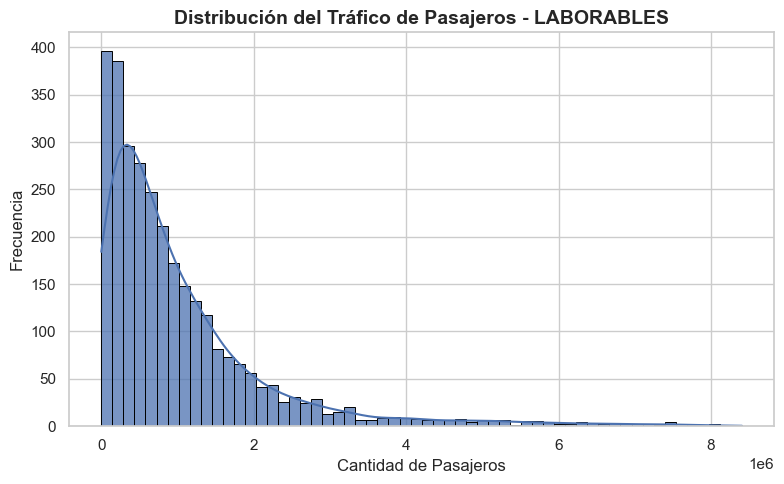

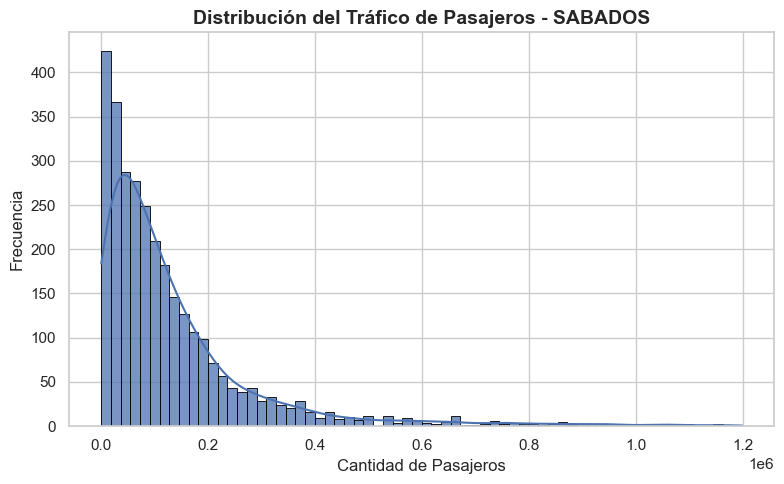

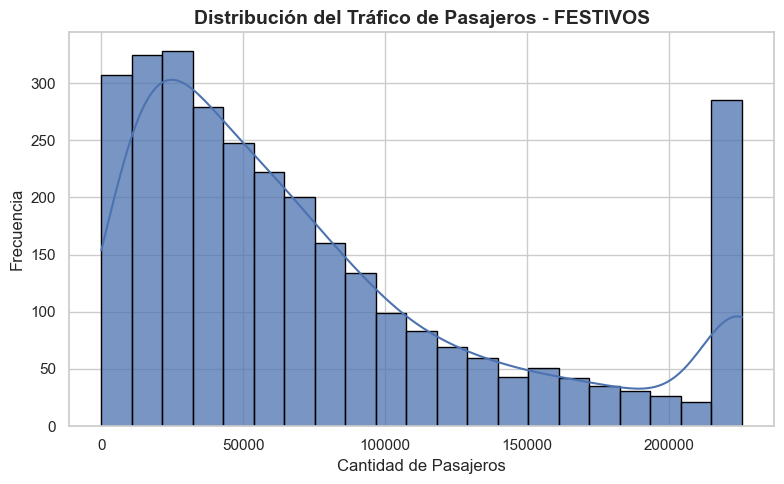

In [22]:
sns.set(style="whitegrid")  

for col in ["LABORABLES", "SABADOS", "FESTIVOS"]:
    plt.figure(figsize=(8,5))

    # Histograma con KDE opcional
    sns.histplot(
        df_sin_outliers[col].dropna(),
        bins="auto",
        kde=True,
        color="#4C72B0",
        edgecolor="black",
        alpha=0.75
    )
    
    plt.title(f"Distribución del Tráfico de Pasajeros - {col}", fontsize=14, weight='bold')
    plt.xlabel("Cantidad de Pasajeros")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

Extra -Correlaciones

In [23]:
correlaciones = df_sin_outliers[["LABORABLES","SABADOS","FESTIVOS"]].corr()
print(correlaciones)

            LABORABLES   SABADOS  FESTIVOS
LABORABLES    1.000000  0.979432  0.827930
SABADOS       0.979432  1.000000  0.856709
FESTIVOS      0.827930  0.856709  1.000000


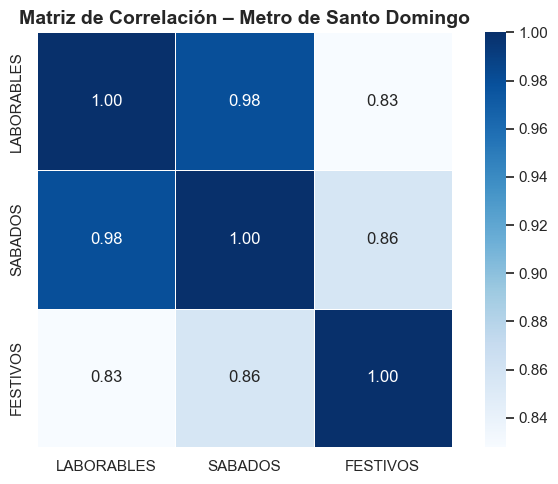

In [24]:
plt.figure(figsize=(7,5))
sns.heatmap(
    correlaciones,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    linewidths=.5,
    square=True
)

plt.title("Matriz de Correlación – Metro de Santo Domingo", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
